# Demo Script for Milestone 10.15

## 0 Prepare task

### 0.1 prepare planning scene

#### Run shared detector on bash
```bash
python3 /home/kiro-ros/Projects/rnb-planning/src/scripts/milestone_202110/utils/shared_detector.py
```

#### Check and request ip setting from mobile udp client (robot-side)

#### 0.1.1 Set parameters and create planning scene

In [1]:
import numpy as np

CONNECT_CAM = True
ENABLE_DETECT = True
ENABLE_O3D = True

CONNECT_INDY = True
CONNECT_MOBILE = True

CONNECT_TASK_PLANNER = False
VISUALIZE = False
VERBOSE = False
PLANNING_MULTIPROC = True
N_AGENTS = 10
NODE_TRIAL_MAX = N_AGENTS * 2
MAX_SOL_NUM = 5
BASE_COST_CUT = 110

TIMEOUT_MOTION = 0.5
TIMEOUT_FULL = 5

ROS_MASTER_ON_MOBILE = False
# Tool dimensions
TOOL_DIM = [0.15, 0.32]
# TOOL_OFFSET = 0.01
TOOL_OFFSET = 0.02 # tested one
MARGIN = 0
TRACK_THICKNESS = 0.001

INDY_BASE_OFFSET = (0.172,0,0.439)
INDY_BASE_RPY = (0,0,0)
TOOL_NAME = "brush_face"
WALL_THICKNESS = 0.01
CLEARANCE = 0.001

IP_CUR = "192.168.0.10"# get_ip_address()
MOBILE_IP = "192.168.0.102"
INDY_IP = "192.168.0.3"

print("Current PC IP: {}".format(IP_CUR))
print("Mobile ROB IP: {}".format(MOBILE_IP))

Current PC IP: 192.168.0.10
Mobile ROB IP: 192.168.0.102


In [2]:
from demo_proto.TaskExecuteServer import serve_on_thread

In [3]:
if CONNECT_TASK_PLANNER:
    servicer = serve_on_thread()

In [4]:
import os
import sys
sys.path.append(os.path.join(os.path.join(
    os.environ["RNB_PLANNING_DIR"], 'src')))
sys.path.append(os.path.join(
    os.environ["RNB_PLANNING_DIR"], 'src/scripts/milestone_202110'))

from pkg.global_config import RNB_PLANNING_DIR
from pkg.utils.utils import *    
from pkg.utils.rotation_utils import *
from pkg.controller.combined_robot import *
from demo_utils.detect_table import *
from demo_utils.area_select import *
from pkg.detector.aruco.marker_config import get_aruco_map
aruco_map = get_aruco_map()

from pkg.geometry.builder.scene_builder import SceneBuilder
from demo_utils.environment import *
from demo_utils.area_select import DATASET_DIR, SweepDirections

from utils.stream_server import *
from utils.detection_util import *


from pkg.utils.shared_function import *
clear_channels_on("kiromobilemap")

mobile_config = RobotConfig(0, RobotType.kmb, ((0,0,0), (0,0,0)),
                "{}/{}".format(MOBILE_IP, IP_CUR), 
                            specs={"dummy":not CONNECT_MOBILE})
robot_config = RobotConfig(1, RobotType.indy7, 
                           (INDY_BASE_OFFSET, INDY_BASE_RPY),
                INDY_IP, root_on="kmb0_platform", 
                           specs={"no_sdk":True})
MOBILE_NAME = mobile_config.get_indexed_name()
ROBOT_NAME = robot_config.get_indexed_name()
crob = CombinedRobot(robots_on_scene=[mobile_config, robot_config]
              , connection_list=[True, CONNECT_INDY])

s_builder = SceneBuilder(None)
SceneBuilder.autostart_roscore = not ROS_MASTER_ON_MOBILE
gscene = s_builder.create_gscene(crob)

gtems = s_builder.add_robot_geometries(
    color=(1,1,1,0.2), display=True, collision=True)
gscene.set_workspace_boundary(
    -4, 12, -7, 5, -CLEARANCE, 3, thickness=WALL_THICKNESS)


from pkg.planning.scene import PlanningScene
pscene = PlanningScene(gscene, combined_robot=crob)

ROBOT_BASE = pscene.robot_chain_dict[ROBOT_NAME]['link_names'][0]
TIP_LINK = pscene.robot_chain_dict[ROBOT_NAME]["tip_link"]
MOBILE_BASE = pscene.robot_chain_dict[MOBILE_NAME]["tip_link"]
HOLD_LINK = MOBILE_BASE

viewpoint = add_cam(gscene, tool_link=TIP_LINK)
# add_indy_tool_kiro(gscene, tool_link=TIP_LINK, 
# face_name=TOOL_NAME, zoff=TOOL_OFFSET)

HOME_POSE = -crob.home_pose
HOME_DICT = list2dict(HOME_POSE, gscene.joint_names)

from pkg.planning.pipeline import PlanningPipeline
ppline = PlanningPipeline(pscene)

# Set planner
from pkg.planning.motion.moveit.moveit_planner import MoveitPlanner
from pkg.planning.filtering.grasp_filter import GraspChecker
mplan = MoveitPlanner(pscene, enable_dual=False, 
                      incremental_constraint_motion=True)
mplan.motion_filters = [GraspChecker(pscene)]
mplan.update_gscene()
gcheck = GraspChecker(pscene)
mplan.motion_filters = [gcheck]

mplan.reset_PRQdict(enable_PRQ=True, radii=5e-2)
for tip_dir, SWEEP_AXIS in [
    (SweepDirections.front, "Z"), (SweepDirections.front, "X"), (SweepDirections.up, "Z"), (SweepDirections.down, "Z")]:
    filename = SweepDirections.get_file_name(RobotType.indy7, tip_dir.name+SWEEP_AXIS)+"-PRQ.pkl"
    PRQ_PATH = os.path.join(DATASET_DIR, filename)
    try:
        Pos_Rotvec_Qlist_dict = load_pickle(PRQ_PATH)
        mplan.register_PRQ(ROBOT_NAME, Pos_Rotvec_Qlist_dict, decimal=2)
        print("Loaded: {}".format(filename))
    except:
        print("File not exist: {}".format(filename))
        continue

from pkg.planning.task.rrt import TaskRRT
tplan = TaskRRT(pscene, node_trial_max=NODE_TRIAL_MAX)
tplan.prepare()
ppline.set_motion_planner(mplan)
ppline.set_task_planner(tplan)


add_kiro_indytool_down(gscene, zoff=TOOL_OFFSET, 
                       tool_link=TIP_LINK, face_name=TOOL_NAME, tool_dim=TOOL_DIM)

# Register binders
from pkg.planning.constraint.constraint_actor import VacuumTool, \
    Gripper2Tool, PlacePlane, SweepFramer

brush_face = pscene.create_binder(
    bname=TOOL_NAME, gname=TOOL_NAME, _type=SweepFramer, 
    point=(0,0, -gscene.NAME_DICT['brush_face'].dims[2]/2-CLEARANCE), 
    rpy=(0,0,0))

gscene.create_safe(
    gtype=GEOTYPE.BOX, name="floor_box", link_name="base_link",
    dims=(15,15,0.4), center=(0,0,0), rpy=(0,0,0), 
    color=(1, 1, 1, 0.1), display=True, collision=False, fixed=True)

gscene.add_highlight_axis("hl", "base_coord", T=np.identity(4), dims=(0.5,0.1,0.1))

kmb = crob.robot_dict["kmb0"]
indy = crob.robot_dict["indy1"]
mobile_box = gscene.NAME_DICT['kmb0_platform_Box_2']

if CONNECT_MOBILE:
    assert np.sum(np.abs(get_xyzw_cur()))>1e-4, "UDP Server not connected"
    
if CONNECT_CAM:
    camgen = CameraGenerator()

connection command:
kmb0: True
indy1: True
[MOBILE ROBOT] bind: ('192.168.0.10', 50306)
[MOBILE ROBOT] Start UDP THREAD
goal reach: 0 -> 1 (1638186819.81)
goal reach signal edge up
Connect: Server IP (192.168.0.3)
Unable to register with master node [http://localhost:11311]: master may not be running yet. Will keep trying.
Please create a subscriber to the marker
publication OK
published: [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
Please create a subscriber to the marker
Loaded: indy7-frontZ-PRQ.pkl
Loaded: indy7-frontX-PRQ.pkl
Loaded: indy7-upZ-PRQ.pkl
Loaded: indy7-downZ-PRQ.pkl


#### 0.1.2 Load environment map

In [5]:
from demo_utils.ros_map_utils import KiroMobileMap
kmm = KiroMobileMap(MOBILE_IP, IP_CUR, CONNECT_MOBILE)
            
VALID_BOX_SCALE = 0.8
VALID_SCORE_CUT = 50
kmb.coster = (lambda Q: 
                  np.max(
                      kmm.get_box_costs(mobile_box, Q, kmm.T_bi, kmm.cost_im, kmm.resolution, 
                                        scale=VALID_BOX_SCALE)))
kmb.cost_cut = VALID_SCORE_CUT
kmb.gscene = gscene

kmm.init_node(timeout=10)

In [6]:
pole_pt_list, pole_res = kmm.update_map(gscene, crob, MOBILE_BASE, timeout=100)

Connect: Server IP (192.168.0.3)
[WARN] Vertices for mesh should be have center point (0,0,0). Auto adjusting.


## 1. Detect scene

### 1.0 Wait task start queue

### 1.1 Detect bed

In [7]:
from utils.shared_detector import SharedDetector
sd = SharedDetector()
if ENABLE_DETECT:
    sd.init()

In [8]:
if CONNECT_TASK_PLANNER:
    while servicer.object_info_running.object_id < 0:
        time.sleep(1)

#### 1.1.1 Move to bed-seek pose 

In [9]:
Q_CUR = kmb.get_qcur()

VIEW_POSE = np.deg2rad([  0., 50.,  -70.,  -0.,  -90., 0])
VIEW_LOC = list(Q_CUR[:6])
VIEW_POSE_EXT = np.array(VIEW_LOC + list(VIEW_POSE))
if CONNECT_INDY:
    with indy:
        indy.joint_move_to(np.rad2deg(VIEW_POSE))
        time.sleep(0.5)
        indy.wait_for_move_finish()
        Qcur = np.deg2rad(indy.get_joint_pos())
else:
    Qcur = VIEW_POSE
gscene.show_pose(VIEW_POSE_EXT)

Connect: Server IP (192.168.0.3)
Move finished!


Connect: Server IP (192.168.0.3)


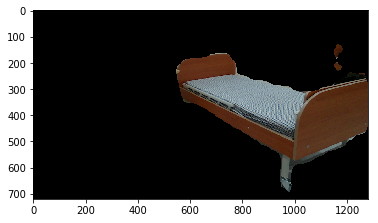

In [10]:
turn_dir = 1
Q0 = np.rad2deg(VIEW_POSE_EXT[6:])
dQ = np.zeros(6)
while True:
    # Take a picture again after rotate
    if CONNECT_CAM:
        rdict = camgen.stream_capture_image(obj_type="bed", crob=crob)
    else:
        rdict, VIEW_POSE_EXT = load_rdict("bed")
        

    cdp = rdict2cdp(rdict)
        
    
    if ENABLE_DETECT:
        # Output of inference(mask for detected table)
        mask_out = sd.inference(color_img=rdict['color'])
        cv2.imwrite(os.path.join(SAVE_DIR, "mask_bed.png"), mask_out)
    else:
        mask_out = cv2.imread(os.path.join(SAVE_DIR, "mask_bed.png"))[:,:,0]
        
    if np.any(mask_out):
        cdp_masked = apply_mask(cdp, mask_out)
        plt.imshow(cdp_masked.color[:,:,[2,1,0]])
        break
    if CONNECT_INDY:
        with indy:
            turn_dir *= -1
            dQ = np.add(dQ, [5,0,0,0,0,0])
            Qto = Q0+turn_dir*dQ
            Qto[0] = (Qto[0]+180/2)%180-180/2
            indy.joint_move_to(Qto)
            indy.wait_motion()
            VIEW_POSE_EXT[6:] = np.deg2rad(indy.get_joint_pos())

#### 1.1.2  detect bed and add to the scene

In [11]:
from pkg.utils.utils import *
gtimer = GlobalTimer.instance()

In [12]:
VISUALIZE = False
T_bc = viewpoint.get_tf(VIEW_POSE_EXT)
T_bc_bed_view = np.copy(T_bc)
T_cb = SE3_inv(T_bc)
gscene.show_pose(VIEW_POSE_EXT)
if ENABLE_O3D:
    icp_bed = MultiICP(model=MODEL_DIR + '/bed/bed_final_rot_res.stl', 
                       Toff=SE3([[0,1,0],[0,0,1],[1,0,0]], [0.455,0,1.02]))
    # Try ICP1
    if np.any(mask_out):
        pcd = icp_bed.add_image(cdp_masked, Tc=None, ratio=0.2)

        Tguess = icp_bed.get_initial_by_center(R=np.matmul(T_cb[:3,:3], Rot_axis(3,np.pi/2)), 
                                               offset=np.matmul(T_cb[:3,:3], (1.1*0.5,0,-0.6)))
        
        with gtimer.block("ICP"):
            Tbs1, fitness1 = icp_bed.compute_ICP(To=Tguess, thres=0.15, visualize=VISUALIZE)
            Tbs2, fitness2 = icp_bed.compute_ICP(None, thres=0.15, visualize=VISUALIZE)
        
    # Better result is adopted
    T_co_bed = Tbs1 if fitness1 > fitness2 else Tbs2
    T_bo_bed = np.matmul(T_bc, T_co_bed)
    
    bed_center = T_bo_bed[:3,3]
    T_bo_new = align_z(T_bo_bed)
    bed_rpy = Rot2rpy(T_bo_new[:3,:3])

    # adjust
    bed_center[2]=0
    Tbm = gscene.get_tf(MOBILE_BASE, VIEW_POSE_EXT)
    Tmo = np.matmul(SE3_inv(Tbm), T_bo_new)
    if Tmo[0,0] > 0:
        bed_rpy[2] += np.pi

    bed_mat = add_bed(gscene, bed_center, bed_rpy, (0,1,0,0.3))
    if VISUALIZE: # show final result
        icp_bed.draw(np.matmul(T_cb, gscene.NAME_DICT["bed_vis"].get_tf(VIEW_POSE_EXT)))
    
else:
    bed_center = (5.1,-0.1,0)
    bed_rpy = (0,0,np.pi)
    bed_mat = add_bed(gscene, bed_center, bed_rpy, (0,1,0,0.3))

bed_vis = gscene.NAME_DICT["bed_vis"]

Apply point-to-point ICP
registration::RegistrationResult with fitness=8.445658e-01, inlier_rmse=4.960540e-02, and correspondence_set size of 4950
Access transformation to get result.
Transformation is:
[[ 0.87573765 -0.10052664  0.47220548 -0.22329355]
 [-0.2572736  -0.92480772  0.28025167  0.22771322]
 [ 0.40852651 -0.36691291 -0.83575177  3.68460444]
 [ 0.          0.          0.          1.        ]]
:: Downsample with a voxel size 0.040.
:: Estimate normal with search radius 0.080.
:: Compute FPFH feature with search radius 0.240.
:: Downsample with a voxel size 0.040.
:: Estimate normal with search radius 0.080.
:: Compute FPFH feature with search radius 0.240.
Apply point-to-point ICP
registration::RegistrationResult with fitness=0.000000e+00, inlier_rmse=0.000000e+00, and correspondence_set size of 0
Access transformation to get result.
Transformation is:
[[ 0.88344249 -0.19940663  0.42398864 -1.37165738]
 [-0.0493553  -0.93948649 -0.33901207  1.4260336 ]
 [ 0.46593285  0.27857

In [13]:
# Front ICP - refine the position of bed
VISUALIZE = False
T_bc_new = viewpoint.get_tf(VIEW_POSE_EXT)
T_bo_new = bed_vis.get_tf(VIEW_POSE_EXT)
Tco_guess = np.matmul(SE3_inv(T_bc_bed_view), T_bo_new)
T_cc = np.matmul(SE3_inv(T_bc_bed_view), T_bc_new)

with gtimer.block("ICP"):
    Tbs_f, fitness_f = icp_bed.compute_front_ICP(
        T_cc, To=Tco_guess, thres=0.15, visualize=VISUALIZE)


T_bo_bed = np.matmul(T_bc, Tbs_f)
bed_center = T_bo_bed[:3,3]
T_bo_new = align_z(T_bo_bed)
bed_rpy = Rot2rpy(T_bo_new[:3,:3])

# adjust
bed_center[2]=0
Tbm = gscene.get_tf(MOBILE_BASE, VIEW_POSE_EXT)
Tmo = np.matmul(SE3_inv(Tbm), T_bo_new)
if Tmo[0,0] > 0:
    bed_rpy[2] += np.pi
move_bed(gscene, bed_center, bed_rpy)

Apply point-to-point ICP
registration::RegistrationResult with fitness=8.808853e-01, inlier_rmse=4.808027e-02, and correspondence_set size of 2189
Access transformation to get result.
Transformation is:
[[ 0.87158681 -0.0928915   0.48136021 -0.24526485]
 [-0.25148483 -0.92756761  0.27635796  0.23383894]
 [ 0.42082283 -0.36192472 -0.83181648  3.67001777]
 [ 0.          0.          0.          1.        ]]


### 1.2 Detect Closet

#### 1.2.1  move to full view position

##### calc fule view pose

In [14]:
VIEW_MOVED = np.deg2rad([  0., 60.,  -60.,  -0.,  -100., 0])
# VIEW_MOVED = np.deg2rad([  0., -10.,  -0.,  -0.,  -100., 0])
VIEW_POSE_EXT[crob.idx_dict[ROBOT_NAME]] = VIEW_MOVED

bed_vis = gscene.NAME_DICT["bed_vis"]
T_bo = bed_vis.get_tf(list2dict(VIEW_POSE_EXT, gscene.joint_names))

if ENABLE_O3D:
    h_fov_hf = np.arctan2(cdp.intrins[0], 2*cdp.intrins[2])
    # Determine the location of closet
    CLOSET_LOCATION = check_location_top_table(
        cdp2pcd(cdp), cdp2pcd(cdp_masked), T_bc, T_bo, 
        bed_dims=bed_mat.dims, visualize=False)
    print("CLOSET on {}".format(CLOSET_LOCATION))
else:
    h_fov_hf = np.pi/4
    CLOSET_LOCATION = "LEFT"
    
if CLOSET_LOCATION == "LEFT":
    angle_refs = [150]
elif CLOSET_LOCATION == "RIGHT":       
    angle_refs = [-150]
    
bed_dim = np.linalg.norm(bed_mat.dims)
x_z_ratio = np.tan(h_fov_hf)
bed_dist = (bed_dim/2) / x_z_ratio * 3
for angle_ref in angle_refs:
    for _ in range(100):
        angle_view = angle_ref + np.random.uniform(-10, 10)
        dist_view = bed_dist + np.random.uniform(-1, 1)*bed_dist/4
        Tbs = bed_mat.get_tf(VIEW_POSE_EXT)
        Tbs = np.matmul(Tbs, 
                        SE3(np.identity(3), (-bed_mat.dims[0]/2, 0,0)))
        Tsc = np.matmul(SE3(Rot_axis(3, np.deg2rad(angle_view)), (0,)*3), 
                        SE3(np.identity(3), (-dist_view, 0,0)))
        Tbc = np.matmul(Tbs, Tsc)
        Tmc = viewpoint.get_tf(VIEW_POSE_EXT, from_link=MOBILE_BASE)
        Tmc[:3,:3] = np.identity(3)
        Tbm = np.matmul(Tbc, SE3_inv(Tmc))
        full_view_ext = np.copy(VIEW_POSE_EXT)
        full_view_ext[:2] = Tbm[:2,3]
        full_view_ext[2] = Rot2axis(Tbm[:3, :3], 3)
        gscene.show_pose(full_view_ext)
        res = kmb.check_valid(full_view_ext[:6])
        if res:
            VIEW_MOVED_EXT = full_view_ext
            print("Full view loc: {}".format(np.round(VIEW_MOVED_EXT[:3], 2)))
            break
    if res:
        break

CLOSET on LEFT
Full view loc: [ 6.64 -1.96 -2.12]


##### move to full view pose

In [15]:
if CONNECT_INDY and CONNECT_MOBILE:
    gscene.show_pose(crob.get_real_robot_pose())
    print("real_robot_pose: {}".format(
        np.round(crob.get_real_robot_pose(), 2)))

Connect: Server IP (192.168.0.3)
Connect: Server IP (192.168.0.3)
real_robot_pose: [ 7.03 -1.66 -2.1   0.    0.    0.    0.    0.87 -1.22 -0.   -1.57 -0.  ]


In [16]:
# VIEW_MOVED = VIEW_POSE
# VIEW_MOVED_EXT = VIEW_POSE_EXT
# CLOSET_LOCATION = "LEFT"

In [17]:
gscene.show_pose(VIEW_MOVED_EXT)

In [18]:
if CONNECT_INDY:
    with indy:
        indy.joint_move_to(np.rad2deg(VIEW_MOVED))
    kmb.joint_move_make_sure(VIEW_MOVED_EXT[:6])
    VIEW_MOVED_EXT = crob.get_real_robot_pose()
if not CONNECT_INDY:
    VIEW_MOVED_EXT[6:] = VIEW_MOVED.copy()
gscene.show_pose(VIEW_MOVED_EXT)
print("VIEW_MOVED_EXT: {}".format(
    np.round(VIEW_MOVED_EXT, 2)))

Connect: Server IP (192.168.0.3)
[INFO] Depart via: [ 6.93 -1.73 -2.1 ] (27.0) <- [ 7.03 -1.66 -2.1 ] (80.0)
Send to mobile: [ 7.033 -1.661 -0.868  0.497]
             -> [ 6.926 -1.727  0.868 -0.497  0.   ]
Distance=0.125474157109 ([-0.107 -0.066  0.   ])
goal reach: 1 -> 0 (1638186856.31)
goal reach: 0 -> 1 (1638186859.9)
goal reach signal edge up
End up at=[ 6.907 -1.729 -2.098] (0.0199 / 0.0199)
Send to mobile: [ 6.907 -1.729 -0.867  0.499]
             -> [ 6.642 -1.964  0.872 -0.49   0.   ]
Distance=0.494866274353 ([-0.391 -0.303 -0.015])
goal reach: 1 -> 0 (1638186861.11)
goal reach: 0 -> 1 (1638186868.81)
goal reach signal edge up
End up at=[ 6.611 -1.964 -2.102] (0.0338 / 0.0338)
Connect: Server IP (192.168.0.3)
VIEW_MOVED_EXT: [ 6.61 -1.96 -2.1   0.    0.    0.   -0.    1.05 -1.05  0.   -1.75  0.  ]


#### 1.2.2 redetect bed

Connect: Server IP (192.168.0.3)
Apply point-to-point ICP
registration::RegistrationResult with fitness=7.421633e-01, inlier_rmse=4.286489e-02, and correspondence_set size of 4309
Access transformation to get result.
Transformation is:
[[-0.99755384  0.02932144  0.06345536  5.17307903]
 [ 0.06204239 -0.04681801  0.99697483 -4.73114408]
 [ 0.03220359  0.998473    0.04488431 -0.10913609]
 [ 0.          0.          0.          1.        ]]


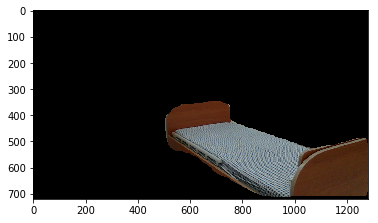

In [19]:
VISUALIZE = False
T_bc = viewpoint.get_tf(VIEW_MOVED_EXT)
# capture image of full view
if CONNECT_CAM:
    rdict = camgen.stream_capture_image(obj_type="full_view", crob=crob)
    
else:
    rdict, VIEW_MOVED_EXT = load_rdict("full_view")
    T_bc = viewpoint.get_tf(VIEW_MOVED_EXT)
    gscene.show_pose(VIEW_MOVED_EXT)
    
cdp = rdict2cdp(rdict)

if ENABLE_DETECT:
    # Output of inference(mask for detected table)
    mask_out = sd.inference(color_img=cdp.color)
    cv2.imwrite(os.path.join(SAVE_DIR, "mask_bed_re.png"), mask_out)
else:
    mask_out = cv2.imread(os.path.join(SAVE_DIR, "mask_bed_re.png"))[:,:,0]
    
if np.any(mask_out):
    cdp_masked = apply_mask(cdp, mask_out)
    plt.imshow(cdp_masked.color[:,:,[2,1,0]])

    icp_bed.clear()
    pcd = icp_bed.add_image(cdp_masked, Tc=T_bc, ratio=0.2)
    T_bs_pre = gscene.NAME_DICT["bed_vis"].get_tf(VIEW_MOVED_EXT)
    T_bo_bed, fitness = icp_bed.compute_ICP(To=T_bs_pre, thres=0.12, visualize=VISUALIZE)
#         # front_ICP
#         T_bo_bed, fitness = icp_bed.compute_front_ICP(T_bc, To=T_bs_pre, thres=0.12, visualize=VISUALIZE)
    # adjust
    T_bo_bed[2]=0
    T_bo_bed[:3, :3]=Rot_axis(3, Rot2axis(T_bo_bed[:3, :3], 3))
    move_bed(gscene, T_bo_bed[:3,3], Rot2rpy(T_bo_bed[:3,:3]))

    if VISUALIZE: # show final result
        icp_bed.draw(gscene.NAME_DICT["bed_vis"].get_tf(VIEW_MOVED_EXT))
else:
    raise(RuntimeError("bed not detected"))

#### 1.2.3  detect and add closet

In [20]:
VISUALIZE = False
if ENABLE_O3D:
    icp_closet = MultiICP(model=MODEL_DIR + '/top_table/top_table.STL', 
                       Toff=SE3([[1,0,0],[0,0,1],[0,-1,0]], [0.3,0,0.2725]))
    
    if CONNECT_CAM:
        rdict = camgen.stream_capture_image(obj_type="top_table", crob=crob)
    else:
        rdict, VIEW_MOVED_EXT = load_rdict("top_table")

    T_bc = viewpoint.get_tf(VIEW_MOVED_EXT)
    
    cdp = rdict2cdp(rdict)
    pcd_closet = cdp2pcd(cdp, T_bc)
    
    
    pcd_masked = mask_boxes(pcd_closet, 
                        boxes=[gscene.NAME_DICT["bed_{}_space".format(CLOSET_LOCATION.lower())]], 
                        Q=VIEW_MOVED_EXT, inside=True, 
                        merge_rule=np.all, link_ref="base_link")
    pcd_masked = mask_boxes(pcd_masked, 
                        boxes=[gscene.NAME_DICT["bed_box"], 
                               gscene.NAME_DICT["bed_wall"], 
                               gscene.NAME_DICT["floor_box"]], 
                        Q=VIEW_MOVED_EXT, inside=False, 
                        merge_rule=np.all, link_ref="base_link")
    pcd_masked, ind = pcd_masked.remove_radius_outlier(nb_points=20, radius=0.06)
    icp_closet.add_pointcloud(pcd_masked, T_bc, ratio=0.2)
    
    Tbs = bed_vis.get_tf(VIEW_MOVED_EXT)
    initial_guess = icp_closet.get_initial_by_median(
        Tbs[:3, :3], 
        np.matmul(T_bc[:3,:3], (0,0,0.3))-(0,0,1))
    with gtimer.block("ICP"):
        T_bo, fitness = icp_closet.compute_front_ICP(T_bc, initial_guess, thres=0.05, visualize=VISUALIZE)
    
#     # front_cut_ICP
#     T_bo, fitness = icp_closet.compute_front_cut_ICP("closet",
#                            initial_guess, thres=0.05, visualize=VISUALIZE)
    
    #adjust
    T_bo[2]=0
    T_bo[:3, :3]=Rot_axis(3, Rot2axis(T_bo[:3, :3], 3))
#     gscene.show_point_cloud(pcd_closet.points, "allpoints", color=(0,0,0,0.5), dims=(0.01,0.01,0.01), sample_to=500)
#     gscene.show_point_cloud(pcd_masked.points, "masked", color=(1,0,0,1), dims=(0.02,0.02,0.02))
else:
    T_bo = T_xyzrpy((np.matmul(Rot_rpy(bed_rpy), (-0.75,-1.5,0))+bed_center, 
                     bed_rpy))
    
closet_leftup, closet_rightup, closet_down = add_closet(
    gscene, closet_center=T_bo[:3,3], closet_rpy=Rot2rpy(T_bo[:3,:3]), 
    COLOR_CLOSET_COL=(0,1,0,0.3))

add_backwall(gscene)

Connect: Server IP (192.168.0.3)
Apply point-to-point ICP
registration::RegistrationResult with fitness=2.763692e-01, inlier_rmse=1.493774e-02, and correspondence_set size of 545
Access transformation to get result.
Transformation is:
[[  3.57357007e-02   2.68969516e-02   9.98999264e-01   5.45654081e+00]
 [  9.99360747e-01  -1.99782151e-03  -3.56948424e-02  -4.79725737e+00]
 [  1.03573977e-03   9.99636215e-01  -2.69511512e-02   4.41499555e-02]
 [  0.00000000e+00   0.00000000e+00   0.00000000e+00   1.00000000e+00]]


In [21]:
pole_pt_list = kmm.remove_poles_by_box(gscene, gscene.NAME_DICT["bed_box"], 
                    pole_pt_list, VIEW_POSE_EXT)
pole_pt_list = kmm.remove_poles_by_box(gscene, gscene.NAME_DICT["closet_box"], 
                    pole_pt_list, VIEW_POSE_EXT)
pole_pt_list = kmm.remove_poles_by_box(gscene, gscene.NAME_DICT["room_box"], 
                    pole_pt_list, VIEW_POSE_EXT, inside=False)
pole_list = kmm.add_pixel_poles("obs_pt", gscene, pole_pt_list, pole_res)
gcheck.ignore_always = pole_list

gscene.update_markers_all() 

In [22]:
from pkg.ui.ui_broker import *

# start UI
ui_broker = UIBroker.instance()
ui_broker.initialize(ppline, s_builder)
ui_broker.start_server()

ui_broker.set_tables()

Dash is running on http://0.0.0.0:8050/

 * Serving Flask app "pkg.ui.dash_launcher" (lazy loading)
 * Environment: production



## 2. Closet cleaning

### 2.0. Prepare functions

In [23]:
from pkg.planning.constraint.constraint_common import *
from pkg.planning.constraint.constraint_actor import *
from pkg.planning.constraint.constraint_subject import *
from pkg.utils.code_scraps import get_look_motion

In [24]:
# mplan.reset_log(flag_log=True)
Q_CUR = VIEW_MOVED_EXT
HOME_POSE_SWEEP = np.copy(Q_CUR)
# HOME_POSE_SWEEP[6:] = 0
crob.home_pose = HOME_POSE_SWEEP
crob.home_dict = list2dict(crob.home_pose, 
                           gscene.joint_names)
floor_ws = gscene.NAME_DICT["floor_ws"]    

brush_face = change_tool(
    pscene, kmb, ToolDir.down, TOOL_OFFSET, TIP_LINK, 
    TOOL_NAME, SweepFramer, clearance=CLEARANCE, tool_dim=TOOL_DIM)

   Use a production WSGI server instead.
 * Debug mode: off
Tool Down


In [25]:
adjust_count_list = []
THRESH = 0.05
def look_closet_get_offset(gxter, crob, mplan, robot_name, Qref):
    Qref_in = np.copy(Qref)
    Qref = np.copy(Qref)
    for _ in range(5):
        traj, succ = get_look_motion(mplan, robot_name, Qref, 
                                     target_point=gscene.NAME_DICT["closet_leftup"],
                                     com_link=pscene.robot_chain_dict[robot_name]['link_names'][-1],
                                     view_dir=[0,0,1],timeout=1)
        traj_rev = np.array(list(reversed(traj)))

    if not succ:
        look_closet_get_offset.Qref_fail = Qref
        raise(RuntimeError("Get Look Motion Fail"))

    Qref[6:] = traj[-1][6:]
    gscene.show_pose(Qref)
    if CONNECT_INDY:
        with indy: # move to look
            crob.move_joint_traj(traj, one_by_one=True)

    time.sleep(1)

    icp_closet = MultiICP(model=MODEL_DIR + '/top_table/top_table.STL', 
                       Toff=SE3([[1,0,0],[0,0,1],[0,-1,0]], [0.3,0,0.2725]))

    adjust_count_list.append(1)
    if CONNECT_CAM:
        rdict = camgen.stream_capture_image( 
                                     obj_type="closet_{}".format(len(adjust_count_list)), 
                                     crob=crob)
    else:
        try:
            rdict, Qref = load_rdict("closet_{}".format(len(adjust_count_list)))
            gscene.show_pose(Qref)
        except Exception as e:
            TextColors.YELLOW.println("[WARN] out of saved look refine data")
            print(e)
            Qcur = np.copy(Qref_in)
            Qcur[:6] = Qref_in[:6] + np.random.uniform([-0.05, -0.05, -0.05, 0, 0, 0],
                                                         [0.05, 0.05, 0.05, 0, 0, 0])

            Qtar = np.copy(Qref_in)
            Qtar[:6] = Qref_in[:6] + np.random.uniform([-0.05, -0.05, -0.05, 0, 0, 0],
                                                         [0.05, 0.05, 0.05, 0, 0, 0])
            return Qcur, Qtar

    T_bc, T_bs_closet = viewpoint.get_tf(Qref), gscene.NAME_DICT["closet_vis"].get_tf(Qref)

    cdp = rdict2cdp(rdict)
    pcd_closet = cdp2pcd(cdp, T_bc)

    with gtimer.block("masking"):
        pcd_masked = mask_boxes(pcd_closet, 
                            boxes=[gscene.NAME_DICT["closet_box"]], 
                            Q=Qref, inside=True, 
                            merge_rule=np.all, link_ref="base_link")
        pcd_masked = mask_boxes(pcd_masked, 
                            boxes=[gscene.NAME_DICT["bed_box"], 
                                   gscene.NAME_DICT["bed_wall"], 
                                   gscene.NAME_DICT["floor_box"],
                                   gscene.NAME_DICT["back_wall"]], 
                            Q=Qref, inside=False, 
                            merge_rule=np.all, link_ref="base_link")

    with gtimer.block("adding"):
        icp_closet.add_pointcloud(pcd_masked, T_bc, ratio=0.2)

    initial_guess = gscene.NAME_DICT["closet_vis"].get_tf(Qref)
    with gtimer.block("compute_front_ICP"):
        # front_ICP
        T_bo_close1, fitness1 = icp_closet.compute_front_ICP(
            T_bc, initial_guess, thres=THRESH, visualize=VISUALIZE)
        T_bo_close = T_bo_close1
#         T_bo_close2, fitness2 = icp_closet.compute_front_ICP(
#             T_bc, initial_guess, thres=THRESH*2, visualize=VISUALIZE)
#         T_bo_close = T_bo_close1 if fitness1 > fitness2 else T_bo_close2

    # calculate transform based on obtained points
    pcd_center_prev = pcd_masked.get_center()

    T_bo_p = SE3(T_bo_close[:3,:3], pcd_center_prev)
    T_pooc = np.matmul(SE3_inv(T_bo_p), T_bo_close)
    T_bo_p[:3,:3] = Rot_axis(3, Rot2axis(T_bo_close[:3,:3], 3))
    T_bo_c_fix = np.matmul(T_bo_p, T_pooc)
    T_bo_c_fix[2,3] = 0

    # get Twoff from redetection
    Tbo0, Tbo1 = T_bs_closet, T_bo_c_fix
    Tbw0 = gscene.get_tf(gxter.mobile_link, Qref)
    Tow1 = np.matmul(SE3_inv(Tbo1), Tbw0)
    Tbw1 = np.matmul(Tbo0, Tow1)

    if CONNECT_CAM and CONNECT_MOBILE:
        Qcur = np.copy(Qref)
        Qcur[:2] = Tbw1[:2,3]
        Qcur[2] = Rot2axis(Tbw1[:3,:3], 3)

        Tow0 = np.matmul(SE3_inv(Tbo0), Tbw0)
        Tbw1tar = np.matmul(Tbo1, Tow0)
        Qtar = np.copy(Qref)
        Qtar[:2] = Tbw1tar[:2,3]
        Qtar[2] = Rot2axis(Tbw1tar[:3,:3], 3)
    else:
        Qcur = np.copy(Qref_in)
        Qcur[:6] = Qref_in[:6] + np.random.uniform([-0.05, -0.05, -0.05, 0, 0, 0],
                                                     [0.05, 0.05, 0.05, 0, 0, 0])
        
        Qtar = np.copy(Qref_in)
        Qtar[:6] = Qref_in[:6] + np.random.uniform([-0.05, -0.05, -0.05, 0, 0, 0],
                                                     [0.05, 0.05, 0.05, 0, 0, 0])
    return Qcur, Qtar

### 2.1. Greedily execute closet cleaning

In [26]:
VISUALIZE = False
UP_OFFSET = 0.02

In [27]:
VEL_LEVEL = 3

if CONNECT_INDY:
    with indy:
        vel_level_bak = indy.get_joint_vel_level()
        print("vel_level_bak: {}".format(vel_level_bak))

    with indy:
        indy.set_joint_vel_level(VEL_LEVEL)
        
    indy.collision_policy = POLICY_NO_COLLISION_DETECTION
swp_fin_list = []

Qcur = VIEW_MOVED_EXT
mode_switcher=ModeSwitcherKMB(pscene, push_dist=0.0)

Connect: Server IP (192.168.0.3)
vel_level_bak: 5
Connect: Server IP (192.168.0.3)


In [28]:
gtimer.reset(scale=1, timeunit='s', stack=True)
gscene.add_virtual_guardrail(closet_rightup, HEIGHT=0.2, margin=0.15)
tplan.node_trial_max = NODE_TRIAL_MAX * 2

brush_face = change_tool(pscene, kmb, ToolDir.down, TOOL_OFFSET+UP_OFFSET,
                         TIP_LINK, TOOL_NAME, SweepFramer, clearance=CLEARANCE, 
                         tool_dim=TOOL_DIM)
gxter = GreedyExecuter(ppline, brush_face, TOOL_DIM, Qcur)
gxter.set_test_kwargs(multiprocess=PLANNING_MULTIPROC, N_agents=N_AGENTS,
                      timeout=TIMEOUT_MOTION*1.5, timeout_loop=TIMEOUT_FULL, 
                      verbose=VERBOSE, max_solution_count=MAX_SOL_NUM)

gxter.get_division_dict(closet_rightup, "up", "Z", None)
gxter.init_base_divs(Qcur)
snode_schedule_list_ru, Qcur, covereds = gxter.greedy_execute(
    Qcur, 1, mode_switcher, look_closet_get_offset, cost_cut=BASE_COST_CUT, adjust_once=False)
gxter.test_clear()
gscene.clear_virtuals()
print(gtimer)

Tool Down
Drift = [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
[INFO] Approach through: [ 6.14 -3.36 -1.61] (66.0) -> [ 5.76 -3.37 -1.61] (109.0)
[INFO] Approach through: [ 6.3  -3.09 -1.61] (20.0) -> [ 6.14 -3.36 -1.61] (66.0)
Send to mobile: [ 6.611 -1.964 -0.868  0.497]
             -> [ 6.302 -3.094  0.72  -0.694  0.   ]
Distance=1.27186127856 ([-0.309 -1.13   0.496])
goal reach: 1 -> 0 (1638186880.0)
goal reach: 0 -> 1 (1638186891.6)
goal reach signal edge up
End up at=[ 6.326 -3.114 -1.637] (0.0432 / 0.0432)
Send to mobile: [ 6.326 -3.114 -0.73   0.683]
             -> [ 6.143 -3.363  0.72  -0.694  0.   ]
Distance=1.55648416411 ([-0.469 -1.399  0.496])
goal reach: 1 -> 0 (1638186892.8)
goal reach: 0 -> 1 (1638186899.31)
goal reach signal edge up
End up at=[ 6.131 -3.379 -1.61 ] (0.0201 / 0.0201)
Send to mobile: [ 6.131 -3.379 -0.721  0.693]
             -> [ 5.76  -3.372  0.72  -0.694  0.   ]
Distance=1.71839650888 ([-0.851 -1.408  0.496])
goal reach: 1 -> 0 (1638186900.5)
g

======================= terminated 0: node queue empty 8th  (2.3/5.0) ===============================
======================= terminated 7: node queue empty 8th  (2.3/5.0) ===============================
[ERROR] Non-joined subprocesses: [6]
========================== FINISHED (0.0 / 5.0 s) ==============================]
Drift = [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
Send to mobile: [ 5.733 -3.509 -0.727  0.686]
             -> [ 5.885 -3.507  0.72  -0.694  0.   ]
Distance=0.153853986589 ([ 0.152  0.002  0.022])
goal reach: 1 -> 0 (1638186941.51)
goal reach: 0 -> 1 (1638186945.61)
goal reach signal edge up
End up at=[ 5.898 -3.505 -1.641] (0.0366 / 0.0366)
Connect: Server IP (192.168.0.3)
Connect: Server IP (192.168.0.3)
Connect: Server IP (192.168.0.3)
Connect: Server IP (192.168.0.3)
Move finished!
Connect: Server IP (192.168.0.3)
Connect: Server IP (192.168.0.3)
Apply point-to-point ICP
registration::RegistrationResult with fitness=2.075875e-01, inlier_rmse=1.524187e-02, 

In [29]:
gtimer.reset(scale=1, timeunit='s', stack=True)
gscene.add_virtual_guardrail(closet_leftup, HEIGHT=0.1, margin=0.1)
tplan.node_trial_max = NODE_TRIAL_MAX

brush_face = change_tool(pscene, kmb, ToolDir.down, TOOL_OFFSET+UP_OFFSET,
                         TIP_LINK, TOOL_NAME, SweepFramer, clearance=CLEARANCE, 
                         tool_dim=TOOL_DIM)
gxter = GreedyExecuter(ppline, brush_face, TOOL_DIM, Qcur)
gxter.set_test_kwargs(multiprocess=PLANNING_MULTIPROC, N_agents=N_AGENTS,
                      timeout=TIMEOUT_MOTION, timeout_loop=TIMEOUT_FULL, 
                      verbose=VERBOSE, max_solution_count=MAX_SOL_NUM)

gxter.get_division_dict(closet_leftup, "up", "Z", None)
gxter.init_base_divs(Qcur)
snode_schedule_list_lu, Qcur, covereds = gxter.greedy_execute(
    Qcur, 1, mode_switcher, look_closet_get_offset, cost_cut=BASE_COST_CUT, covereds=covereds)
gxter.test_clear()
gscene.clear_virtuals()
print(gtimer)

Tool Down
Drift = [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
Send to mobile: [ 5.898 -3.505 -0.731  0.682]
             -> [ 6.015 -3.188  0.72  -0.694  0.   ]
Distance=0.339455764041 ([ 0.117  0.317  0.034])
goal reach: 1 -> 0 (1638186992.5)
goal reach: 0 -> 1 (1638186999.61)
goal reach signal edge up
End up at=[ 6.033 -3.186 -1.646] (0.0438 / 0.0438)
Connect: Server IP (192.168.0.3)
Connect: Server IP (192.168.0.3)
Connect: Server IP (192.168.0.3)
Connect: Server IP (192.168.0.3)
Move finished!
Connect: Server IP (192.168.0.3)
Connect: Server IP (192.168.0.3)
Apply point-to-point ICP
registration::RegistrationResult with fitness=2.138858e-01, inlier_rmse=1.583905e-02, and correspondence_set size of 955
Access transformation to get result.
Transformation is:
[[  5.69188036e-02   3.62161200e-02   9.97721700e-01   5.49140193e+00]
 [  9.98374657e-01   8.08774925e-04  -5.69854116e-02  -4.81831671e+00]
 [ -2.87072280e-03   9.99343654e-01  -3.61112219e-02   1.40724736e-02]
 [  0.0000

======================= terminated 2: node queue empty 10th  (4.5/5.0) ===============================
========================== FINISHED (0.0 / 5.0 s) ==============================]
[PLAN] Try idc (2,)
Use 10/12 agents
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
======================= terminated 7: required answers acquired  (2.5/5.0) ===============================
Goal reached
======================= terminated 4: required answers acquired  (2.5/5.0) ===============================
======================= terminated 3: required answers acquired  (2.6/5.0) ===============================
Goal reached
======================= terminated 8: required answers acquired  (2.6/5.0) ===============================
======================= terminated 1: Stop called from other agent  (2.6/5.0) ===============================
======================= terminated 2: Stop called from other agent  (2.6/5.0) ===============================
Goal reached


======================= terminated 2: node queue empty 5th  (4.3/5.0) ===============================
======================= terminated 0: node queue empty 6th  (4.4/5.0) ===============================
======================= terminated 6: node queue empty 7th  (4.4/5.0) ===============================
======================= terminated 3: node queue empty 8th  (4.4/5.0) ===============================
======================= terminated 1: node queue empty 9th  (4.5/5.0) ===============================
========================== FINISHED (0.0 / 5.0 s) ==============================]
Drift = [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
Send to mobile: [ 6.229 -3.191 -0.724  0.69 ]
             -> [ 6.019 -3.066  0.72  -0.694  0.   ]
Distance=0.244237572001 ([-0.21   0.124  0.011])
goal reach: 1 -> 0 (1638187106.2)
goal reach: 0 -> 1 (1638187111.7)
goal reach signal edge up
End up at=[ 6.017 -3.046 -1.618] (0.0234 / 0.0234)
Connect: Server IP (192.168.0.3)
Connect: Server IP (192.

In [30]:
gtimer.reset(scale=1, timeunit='s', stack=True)
gscene.add_virtual_guardrail(closet_leftup, HEIGHT=0.1, margin=0.1)
tplan.node_trial_max = NODE_TRIAL_MAX

brush_face = change_tool(pscene, kmb, ToolDir.up, TOOL_OFFSET+UP_OFFSET, 
                         TIP_LINK, TOOL_NAME, SweepFramer, clearance=CLEARANCE, 
                         tool_dim=TOOL_DIM)
gxter = GreedyExecuter(ppline, brush_face, TOOL_DIM, Qcur)
gxter.set_test_kwargs(multiprocess=PLANNING_MULTIPROC, N_agents=N_AGENTS,
                        timeout=TIMEOUT_MOTION, timeout_loop=TIMEOUT_FULL, 
                        verbose=VERBOSE, max_solution_count=MAX_SOL_NUM)

gxter.get_division_dict(closet_leftup, "front", "Z", None)
gxter.init_base_divs(Qcur)
snode_schedule_list_lf, Qcur, covereds = gxter.greedy_execute(
    Qcur, 1, mode_switcher, look_closet_get_offset, cost_cut=BASE_COST_CUT)
gxter.test_clear()
gscene.clear_virtuals()
print(gtimer)

Tool UP
Drift = [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
Send to mobile: [ 6.175 -3.109 -0.724  0.69 ]
             -> [ 6.017 -3.131  0.72  -0.694  1.   ]
Distance=0.160688321858 ([-0.159 -0.023  0.011])
goal reach: 1 -> 0 (1638187179.0)
goal reach: 0 -> 1 (1638187183.3)
goal reach signal edge up
End up at=[ 6.008 -3.142 -1.618] (0.0179 / 0.0179)
Connect: Server IP (192.168.0.3)
Connect: Server IP (192.168.0.3)
Connect: Server IP (192.168.0.3)
Connect: Server IP (192.168.0.3)
Move finished!
Connect: Server IP (192.168.0.3)
Connect: Server IP (192.168.0.3)
Apply point-to-point ICP
registration::RegistrationResult with fitness=2.084257e-01, inlier_rmse=1.392762e-02, and correspondence_set size of 940
Access transformation to get result.
Transformation is:
[[ 0.08742563  0.03767472  0.99545835  5.46620607]
 [ 0.99609461  0.00907103 -0.08782482 -4.76913364]
 [-0.01233861  0.99924888 -0.03673454  0.01977197]
 [ 0.          0.          0.          1.        ]]
[PLAN] Adjust base on

In [31]:
gtimer.reset(scale=1, timeunit='s', stack=True)
gscene.add_virtual_guardrail(
    closet_down, HEIGHT=0.05, margin=0.1, axis="xy")

brush_face = change_tool(pscene, kmb, ToolDir.up, TOOL_OFFSET,
                         TIP_LINK, TOOL_NAME, SweepFramer, clearance=CLEARANCE, 
                         tool_dim=TOOL_DIM)
gxter = GreedyExecuter(ppline, brush_face, TOOL_DIM, Qcur)
gxter.set_test_kwargs(multiprocess=PLANNING_MULTIPROC, N_agents=N_AGENTS,
                        timeout=TIMEOUT_MOTION, timeout_loop=TIMEOUT_FULL, 
                        verbose=VERBOSE, max_solution_count=MAX_SOL_NUM, show_motion=True)

gxter.get_division_dict(closet_down, "front", "Z", None)
gxter.init_base_divs(Qcur)

snode_schedule_list_lf, Qcur, covereds = gxter.greedy_execute(
    Qcur, 1, mode_switcher, look_closet_get_offset, cost_cut=BASE_COST_CUT)
gxter.test_clear()
gscene.clear_virtuals()
print(gtimer)

Tool UP
Drift = [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
Send to mobile: [ 6.185 -3.105 -0.723  0.69 ]
             -> [ 6.189 -2.974  0.72  -0.694  1.   ]
Distance=0.131463664463 ([ 0.004  0.131  0.011])
goal reach: 1 -> 0 (1638187239.8)
goal reach: 0 -> 1 (1638187244.1)
goal reach signal edge up
End up at=[ 6.189 -2.956 -1.618] (0.0214 / 0.0214)
Connect: Server IP (192.168.0.3)
Connect: Server IP (192.168.0.3)
Connect: Server IP (192.168.0.3)
Connect: Server IP (192.168.0.3)
Move finished!
Connect: Server IP (192.168.0.3)
Connect: Server IP (192.168.0.3)
Apply point-to-point ICP
registration::RegistrationResult with fitness=1.807768e-01, inlier_rmse=1.435023e-02, and correspondence_set size of 647
Access transformation to get result.
Transformation is:
[[ -1.84752354e-03   3.06334750e-02   9.99528951e-01   5.52304257e+00]
 [  9.99853809e-01   1.70455281e-02   1.32571419e-03  -4.85131165e+00]
 [ -1.69968876e-02   9.99385331e-01  -3.06604887e-02   2.53521861e-02]
 [  0.0000000

Connect: Server IP (192.168.0.3)
Move finished!
Connect: Server IP (192.168.0.3)
binder: brush_face
rname: indy1
Connect: Server IP (192.168.0.3)
Connect: Server IP (192.168.0.3)
Connect: Server IP (192.168.0.3)
Connect: Server IP (192.168.0.3)
Move finished!
Connect: Server IP (192.168.0.3)
binder: brush_face
rname: indy1
Connect: Server IP (192.168.0.3)
Connect: Server IP (192.168.0.3)
Connect: Server IP (192.168.0.3)
Connect: Server IP (192.168.0.3)
Move finished!
Connect: Server IP (192.168.0.3)
binder: brush_face
rname: indy1
Connect: Server IP (192.168.0.3)
Connect: Server IP (192.168.0.3)
Connect: Server IP (192.168.0.3)
Connect: Server IP (192.168.0.3)
Move finished!
Connect: Server IP (192.168.0.3)
binder: brush_face
rname: indy1
Connect: Server IP (192.168.0.3)
get_best_base_divs: 	0.0 s/2 = 0.0 s (0.005/0.018)
move_base: 	5.6 s/1 = 5.6 s (5.625/5.625)
offset_fun: 	7.6 s/1 = 7.6 s (7.589/7.589)
masking: 	0.3 s/2 = 0.1 s (0.137/0.139)
adding: 	0.1 s/2 = 0.0 s (0.036/0.052)
com

In [32]:
gtimer.reset(scale=1, timeunit='s', stack=True)
brush_face = change_tool(pscene, kmb, ToolDir.down, TOOL_OFFSET, 
                         TIP_LINK, TOOL_NAME, SweepFramer, clearance=CLEARANCE, 
                         tool_dim=TOOL_DIM)
gscene.add_virtual_guardrail(
    closet_down, HEIGHT=0.05, margin=0.1, axis="xy")
tplan.node_trial_max = NODE_TRIAL_MAX * 2

gxter = GreedyExecuter(ppline, brush_face, TOOL_DIM, Qcur)
gxter.set_test_kwargs(multiprocess=PLANNING_MULTIPROC, N_agents=N_AGENTS,
                      timeout=TIMEOUT_MOTION*2, timeout_loop=TIMEOUT_FULL, 
                      verbose=VERBOSE, max_solution_count=MAX_SOL_NUM)

gxter.get_division_dict(closet_down, "down", "Z", None)
gxter.init_base_divs(Qcur)
snode_schedule_list_d, Qcur, covereds = gxter.greedy_execute(
    Qcur, -1, mode_switcher, look_closet_get_offset, cost_cut=BASE_COST_CUT, 
    covereds=covereds, adjust_once=False)
gxter.test_clear()
gscene.clear_virtuals()
print(gtimer)

Tool Down
Drift = [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
Send to mobile: [ 6.249 -2.98  -0.724  0.69 ]
             -> [ 6.184 -3.129  0.72  -0.694  0.   ]
Distance=0.163305066224 ([-0.065 -0.149  0.012])
goal reach: 1 -> 0 (1638187352.6)
goal reach: 0 -> 1 (1638187356.5)
goal reach signal edge up
End up at=[ 6.171 -3.133 -1.608] (0.0142 / 0.0142)
Connect: Server IP (192.168.0.3)
Connect: Server IP (192.168.0.3)
Connect: Server IP (192.168.0.3)
Connect: Server IP (192.168.0.3)
Move finished!
Connect: Server IP (192.168.0.3)
Connect: Server IP (192.168.0.3)
Apply point-to-point ICP
registration::RegistrationResult with fitness=1.760092e-01, inlier_rmse=1.475264e-02, and correspondence_set size of 763
Access transformation to get result.
Transformation is:
[[ 0.02122034  0.04643912  0.99869568  5.4877192 ]
 [ 0.99960336  0.01751254 -0.02205396 -4.81935545]
 [-0.01851386  0.9987676  -0.04604908  0.02990851]
 [ 0.          0.          0.          1.        ]]
[PLAN] Current posi

======================= terminated 0: max iteration time reached (5.5/5.0 s)  (5.5/5.0) ===============================
======================= terminated 7: max iteration time reached (5.5/5.0 s)  (5.5/5.0) ===============================
======================= terminated 2: max iteration time reached (5.5/5.0 s)  (5.5/5.0) ===============================
======================= terminated 8: max iteration time reached (5.5/5.0 s)  (5.5/5.0) ===============================
======================= terminated 4: max iteration time reached (5.6/5.0 s)  (5.6/5.0) ===============================
======================= terminated 6: max iteration time reached (5.7/5.0 s)  (5.7/5.0) ===============================
========================== FINISHED (0.0 / 5.0 s) ==============================]
Goal reached
Connect: Server IP (192.168.0.3)
Connect: Server IP (192.168.0.3)
Connect: Server IP (192.168.0.3)
Move finished!
Connect: Server IP (192.168.0.3)
binder: brush_face
rname: indy1
Connec

## 3. Bed cleaning

In [33]:
VISUALIZE=False

In [34]:
BED_OFFSET = 0.02

brush_face = change_tool(pscene, kmb, ToolDir.down, 
                         TOOL_OFFSET + BED_OFFSET, 
                         TIP_LINK, TOOL_NAME, 
                         SweepFramer, clearance=CLEARANCE, 
                         tool_dim=TOOL_DIM)

T_e_brush = brush_face.get_tf_handle(crob.home_dict, from_link=TIP_LINK)
T_brush_e = SE3_inv(T_e_brush)
EE_HEIGHT = round(bed_mat.get_tf(HOME_DICT)[2,3] + bed_mat.dims[2]/2, 5) \
                + T_brush_e[2, 3] - INDY_BASE_OFFSET[2]

gscene.add_virtual_guardrail(closet_leftup, HEIGHT=0.02, margin=0.05)
gscene.add_virtual_guardrail(closet_rightup, HEIGHT=0.02, margin=0.05)
gscene.add_virtual_guardrail(closet_down, HEIGHT=0.02, margin=0.05, axis="xy")

Tool Down


In [35]:
gtimer.reset(scale=1, timeunit='s', stack=True)
gxter = GreedyExecuter(ppline, brush_face, TOOL_DIM, Qcur)
tplan.node_trial_max = NODE_TRIAL_MAX

gxter.set_test_kwargs(multiprocess=PLANNING_MULTIPROC, N_agents=N_AGENTS,
                      timeout=TIMEOUT_MOTION, timeout_loop=TIMEOUT_FULL, 
                      verbose=VERBOSE, max_solution_count=MAX_SOL_NUM)

covereds_all = []
for _ in range(1):
    gxter.get_division_dict(bed_mat, "front", "X", EE_HEIGHT, xout_cut=True)
    gxter.init_base_divs(Qcur)
    # gxter.mark_tested(None, None, covereds_all, [])
    snode_schedule_list_d, Qcur, covereds = gxter.greedy_execute(
        Qcur, 1, mode_switcher, look_closet_get_offset, cost_cut=BASE_COST_CUT, covereds=covereds_all, adjust_once=False)
    covereds_all = sorted(set(covereds_all+covereds))
    gxter.test_clear()
    len_covered, len_all = len(covereds_all), len(gxter.surface_div_centers)
    print("########################### TRIAL ONCE DONE ( {} / {} )########################".format(len_covered, len_all))
    if len_covered >= len_all:
        break
    print(gtimer)
gscene.clear_virtuals()

('Height Reference: ', 0.5420000145435333)
Drift = [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
[INFO] Depart via: [ 6.29 -2.82 -1.6 ] (15.0) <- [ 6.08 -3.13 -1.6 ] (101.0)
Send to mobile: [ 6.076 -3.132 -0.717  0.697]
             -> [ 6.286 -2.821  0.717 -0.697  0.   ]
Distance=0.375037182645 ([ 0.21   0.311  0.   ])
goal reach: 1 -> 0 (1638187500.1)
goal reach: 0 -> 1 (1638187507.7)
goal reach signal edge up
End up at=[ 6.294 -2.802 -1.591] (0.0223 / 0.0223)
[INFO] Approach through: [ 6.25 -3.48  3.08] (101.0) -> [ 5.96 -3.74  3.08] (107.590698242)
[INFO] Approach through: [ 6.28 -3.57  3.08] (101.0) -> [ 6.25 -3.48  3.08] (101.0)
[INFO] Approach through: [ 6.3  -3.39  3.08] (101.0) -> [ 6.28 -3.57  3.08] (101.0)
Send to mobile: [ 6.294 -2.802 -0.714  0.7  ]
             -> [ 6.296 -3.394  1.     0.031  0.   ]
Distance=1.71863741561 ([ 0.002 -0.593 -1.613])
goal reach: 1 -> 0 (1638187509.4)
goal reach: 0 -> 1 (1638187520.3)
goal reach signal edge up
End up at=[ 6.262 -3.431  3.

======================= terminated 7: node queue empty 8th  (2.4/5.0) ===============================
======================= terminated 8: node queue empty 9th  (2.4/5.0) ===============================
======================= terminated 0: node queue empty 10th  (2.6/5.0) ===============================
========================== FINISHED (0.0 / 5.0 s) ==============================]
[PLAN] Try idc (4,)
Use 10/12 agents
======================= terminated 0: node queue empty 1th  (2.4/5.0) ===============================
======================= terminated 5: node queue empty 2th  (2.4/5.0) ===============================
======================= terminated 3: node queue empty 3th  (2.5/5.0) ===============================
======================= terminated 7: node queue empty 4th  (2.5/5.0) ===============================
======================= terminated 2: node queue empty 6th  (2.5/5.0) ===============================
======================= terminated 1: node queue empty 6th  (2.5

======================= terminated 0: node queue empty 3th  (2.3/5.0) ===============================
======================= terminated 7: node queue empty 4th  (2.5/5.0) ===============================
======================= terminated 5: node queue empty 5th  (2.5/5.0) ===============================
======================= terminated 3: node queue empty 6th  (2.6/5.0) ===============================
======================= terminated 6: node queue empty 7th  (2.6/5.0) ===============================
======================= terminated 8: node queue empty 8th  (2.6/5.0) ===============================
======================= terminated 9: node queue empty 9th  (2.6/5.0) ===============================
======================= terminated 4: node queue empty 10th  (2.7/5.0) ===============================
========================== FINISHED (0.0 / 5.0 s) ==============================]
[PLAN] Try idc (7,)
Use 10/12 agents
======================= terminated 1: node queue empty 1th  (2.4

======================= terminated 6: node queue empty 9th  (3.3/5.0) ===============================
======================= terminated 8: node queue empty 10th  (3.4/5.0) ===============================
========================== FINISHED (0.0 / 5.0 s) ==============================]
[PLAN] Line idc [9]
[PLAN] Try idc (9,)
Use 10/12 agents
======================= terminated 1: node queue empty 1th  (2.7/5.0) ===============================
======================= terminated 2: node queue empty 2th  (2.7/5.0) ===============================
======================= terminated 0: node queue empty 3th  (2.7/5.0) ===============================
======================= terminated 3: node queue empty 4th  (2.8/5.0) ===============================
======================= terminated 8: node queue empty 5th  (2.8/5.0) ===============================
======================= terminated 6: node queue empty 6th  (2.8/5.0) ===============================
======================= terminated 5: node q

======================= terminated 1: node queue empty 4th  (2.3/5.0) ===============================
======================= terminated 5: node queue empty 5th  (2.3/5.0) ===============================
======================= terminated 6: node queue empty 6th  (2.3/5.0) ===============================
======================= terminated 7: node queue empty 7th  (2.4/5.0) ===============================
======================= terminated 4: node queue empty 8th  (2.4/5.0) ===============================
======================= terminated 9: node queue empty 9th  (2.5/5.0) ===============================
======================= terminated 8: node queue empty 10th  (2.5/5.0) ===============================
========================== FINISHED (0.0 / 5.0 s) ==============================]
[PLAN] Try idc (12,)
Use 10/12 agents
======================= terminated 0: node queue empty 1th  (2.6/5.0) ===============================
======================= terminated 2: node queue empty 2th  (2.

======================= terminated 6: node queue empty 9th  (3.4/5.0) ===============================
======================= terminated 9: node queue empty 10th  (3.5/5.0) ===============================
========================== FINISHED (0.0 / 5.0 s) ==============================]
Drift = [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
[INFO] Depart via: [ 6.19 -3.5   3.1 ] (102.0) <- [ 5.95 -3.76  3.1 ] (107.590698242)
Send to mobile: [ 5.951 -3.756 -1.    -0.02 ]
             -> [ 6.19  -3.503  1.     0.02   0.   ]
Distance=0.348052803402 ([ 0.239  0.253  0.   ])
goal reach: 1 -> 0 (1638187590.0)
goal reach: 0 -> 1 (1638187596.3)
goal reach signal edge up
End up at=[ 6.193 -3.483  3.112] (0.0235 / 0.0235)
[INFO] Approach through: [ 3.35 -3.49 -0.06] (10.0) -> [ 3.61 -3.63 -0.06] (101.0)
[INFO] Depart via: [ 6.25 -3.26  3.11] (101.0) <- [ 6.19 -3.48  3.11] (102.0)
Send to mobile: [ 6.193 -3.483 -1.    -0.015]
             -> [ 6.246 -3.261  1.     0.015  0.   ]
Distance=0.22751

======================= terminated 0: required answers acquired  (2.7/5.0) ===============================
Goal reached
======================= terminated 4: required answers acquired  (3.0/5.0) ===============================
[ERROR] Non-joined subprocesses: [8, 1, 4, 7]
========================== FINISHED (0.0 / 5.0 s) ==============================]
[PLAN] Line idc [8]
[PLAN] Try idc (8,)
Use 10/12 agents
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
======================= terminated 4: required answers acquired  (1.6/5.0) ===============================
Goal reached
======================= terminated 5: required answers acquired  (1.7/5.0) ===============================
Goal reached
======================= terminated 8: required answers acquired  (1.8/5.0) ===============================
Goal reached
======================= terminated 7: required answers acquired  (1.8/5.0) ===============================
Goal reached
======================= termin

======================= terminated 4: required answers acquired  (2.7/5.0) ===============================
======================= terminated 3: Stop called from other agent  (2.7/5.0) ===============================
Goal reached
======================= terminated 8: required answers acquired  (2.8/5.0) ===============================
Goal reached
======================= terminated 2: required answers acquired  (3.0/5.0) ===============================
[ERROR] Non-joined subprocesses: [6, 9, 0]
========================== FINISHED (0.0 / 5.0 s) ==============================]
[PLAN] Line idc [17]
[PLAN] Try idc (17,)
Use 10/12 agents
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
======================= terminated 4: required answers acquired  (1.9/5.0) ===============================
======================= terminated 6: required answers acquired  (1.9/5.0) ===============================
======================= terminated 5: req

KeyboardInterrupt: 

In [ ]:
if CONNECT_TASK_PLANNER:
    servicer.mark_task_finished()

* MAX_SOL_NUM 적용 v
* 위 오른쪽 안닦이는 문제 파악 - guardrail 마진 - v
* 아래 닦을 때 위쪽 가운데 바운더리 추가 - v
* 침대 닦을 때 옷장 바운더리 마진 추가 - v
* 위치 보정, 드리프트 코드 검토 - ok - v
* 인디 툴 무게 v
* 툴 조인트 플래닝에 추가?

* Adjust에서 Qref와 Qcur 분리